In [1]:
import pyconll
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:

def merge_files(locations, new_file):
  files = []
  for loc in locations:
    files += glob.glob(loc)
  res = open(new_file, 'w')
  for file in files:
    with open(file) as fd:
      res.write(fd.read())
  res.close()

In [3]:
merge_files(['./UD_Hebrew-*/*.conllu'], 'he-ud.conllu')

In [4]:
heb = pyconll.load_from_file('he-ud.conllu')

In [5]:
result = []

In [6]:
def all_POS(sentence):
  for token in sentence:
    if token.upos == 'X':
      return False
  return True

def count_words(sentence):
  result = 0
  skip = 0
  for token in sentence:
    if '-' in token.id:
      result += 1
      skip = int(token.id.split('-')[1])
    elif int(token.id) > skip and token.upos != 'PUNCT':
      result += 1
  return result

def count_tokens(sentence):
  result = 0
  for token in sentence:
    if '-' not in token.id:
      result += 1
  return result
  

In [9]:
data = pd.DataFrame([(count_words(sentence), count_tokens(sentence), sentence.text) for sentence in heb if all_POS(sentence)], columns=['words', 'tokens', 'sentence'])

In [8]:
data.words.hist

NameError: name 'data' is not defined

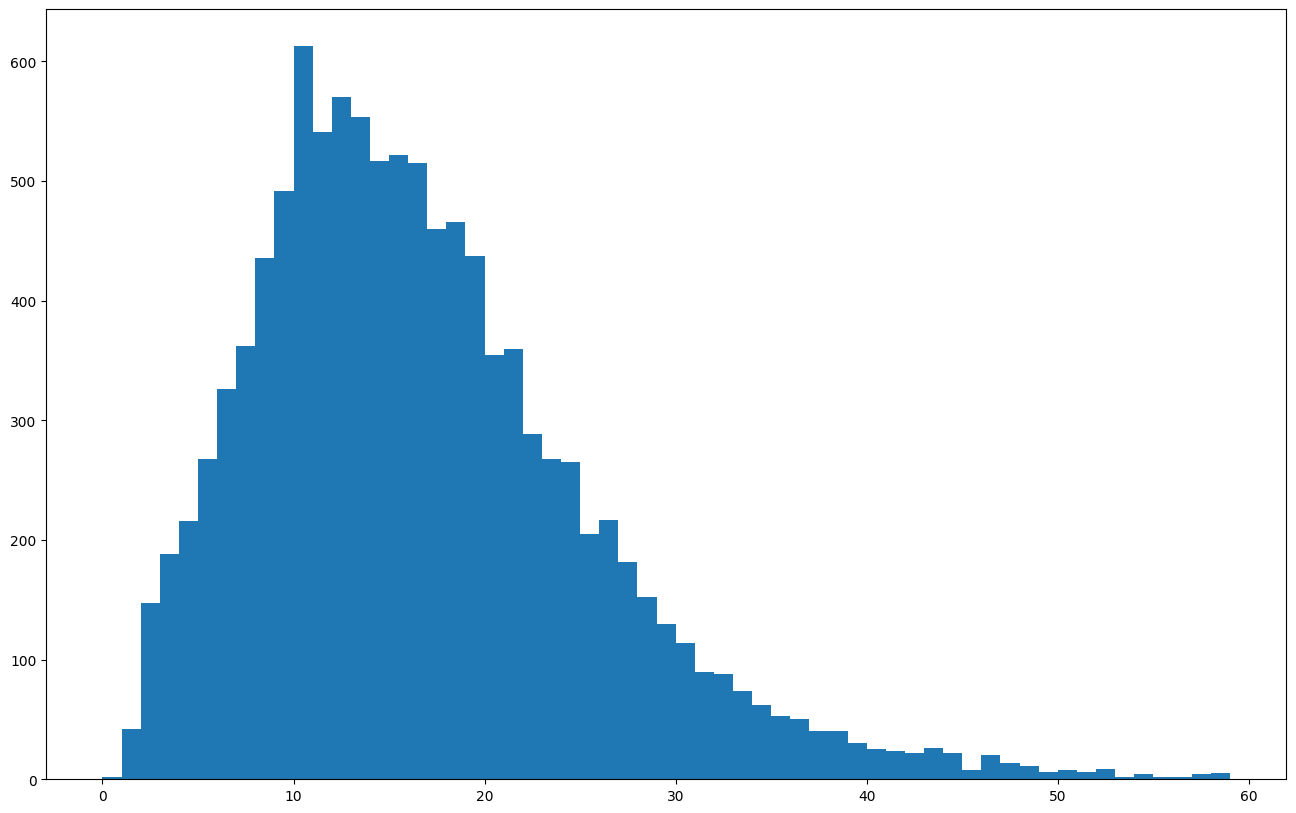

In [10]:
fig = plt.figure(figsize=(16, 10))
plt.hist(data.words, bins=np.arange(60))
plt.show()

In [11]:
ru_data = pd.read_csv(
            "RuSentEval/data/sent_len.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )

In [12]:
count, division = np.histogram(data.words, bins=np.arange(100))

In [13]:
sum(count)

10975

In [15]:
thresholds = np.linspace(0.05, 0.95, num = 7) * sum(count)

In [16]:
threshold_ids = np.searchsorted(np.cumsum(count), thresholds) + 1

In [17]:
threshold_ids

array([ 5, 10, 13, 16, 19, 24, 34])

In [18]:
data['sent_len'] = data['words'].apply(lambda x : (threshold_ids >= x).sum() - 1)

In [91]:
data

,words,tokens,sentence,sent_len
0,30,47,"בגוף בריא לכליות מספר רב של תפקידים, העיקריים ...",0
1,8,11,זהו טיפול תומך שאינו מיועד לרפא את הכליות.,5
2,27,45,דיאליזה מיועדת לחולים קשים שהכליות שלהם חדלו ל...,0
3,15,21,הדיאליזה הוא טיפול במיקרים של שילוב בין היפרקל...,3
4,16,24,בישראל היו בסוף שנת 2017 6700 חולים בטיפול דיא...,3
...,...,...,...,...
10970,17,26,האנטיפסטו של מאכלי ים היה מורכב בעיקר מזרועות ...,2
10971,18,29,"אף שהמנה היתה טעימה, חסרה בה החריפות של פלפלי ...",2
10972,4,7,"כמו שיעולים, שלשול וחום.",6
10973,11,20,הוריהם האמינו ברפואה המודרנית והרופאים המליצו ...,4


In [19]:
sent_len_he = data[(data['sent_len'] >= 0) & (data['sent_len'] < 6)].drop(['words', 'tokens'], axis=1)

In [93]:
sent_len_he

,sentence,sent_len
0,"בגוף בריא לכליות מספר רב של תפקידים, העיקריים ...",0
1,זהו טיפול תומך שאינו מיועד לרפא את הכליות.,5
2,דיאליזה מיועדת לחולים קשים שהכליות שלהם חדלו ל...,0
3,הדיאליזה הוא טיפול במיקרים של שילוב בין היפרקל...,3
4,בישראל היו בסוף שנת 2017 6700 חולים בטיפול דיא...,3
...,...,...
10969,פשטידת קותלי החזיר והירקות היתה חסרת טעם ושימו...,2
10970,האנטיפסטו של מאכלי ים היה מורכב בעיקר מזרועות ...,2
10971,"אף שהמנה היתה טעימה, חסרה בה החריפות של פלפלי ...",2
10973,הוריהם האמינו ברפואה המודרנית והרופאים המליצו ...,4


In [85]:
ru_data

,subset,label,sentence
0,tr,0,Главный герой отправляется в бой .
1,tr,0,Рабочие повредили стволы деревьев .
2,tr,0,Посмотрите на наши расходы .
3,tr,0,Они располагались на северо-восточной стороне ...
4,tr,0,Но информация не подтвердилась .
...,...,...,...
119983,va,5,Наличие неоконченных фраз в конце некоторых те...
119984,va,5,Классификатор должен иметь достаточно большой ...
119985,va,5,"Увидев , что туда пришло слишком мало людей , ..."
119986,va,5,"Сложность и цели пьяных игр сильно варьируют ,..."


In [21]:
sent_len_he = sent_len_he.reset_index()

In [59]:
def add_column_train(data, split_column, val_size, test_size, seed):
  res = data.reset_index()
  classes = data[split_column].unique()
  train_size = 1 - val_size - test_size
  np.random.seed(42)
  res['subset'] = ''
  for label in classes:
    ids = res[res[split_column] == label].index
    perm = np.random.permutation(ids)
    train_point = int(np.floor(len(ids) * train_size))
    val_point = int(np.floor(len(ids) * (train_size + val_size)))
    res['subset'][perm[:train_point]] = 'tr'
    res['subset'][perm[train_point:val_point]] = 'va'
    res['subset'][perm[val_point:]] = 'te'
  return res

In [ ]:
sent_len_splited = add_column_train(sent_len_he, 'sent_len', 0.1, 0.1, 42).drop(['level_0', 'index'], axis=1)

In [65]:
sent_len_splited

,sentence,sent_len,subset
0,"בגוף בריא לכליות מספר רב של תפקידים, העיקריים ...",0,tr
1,זהו טיפול תומך שאינו מיועד לרפא את הכליות.,5,tr
2,דיאליזה מיועדת לחולים קשים שהכליות שלהם חדלו ל...,0,va
3,הדיאליזה הוא טיפול במיקרים של שילוב בין היפרקל...,3,tr
4,בישראל היו בסוף שנת 2017 6700 חולים בטיפול דיא...,3,tr
...,...,...,...
9657,פשטידת קותלי החזיר והירקות היתה חסרת טעם ושימו...,2,te
9658,האנטיפסטו של מאכלי ים היה מורכב בעיקר מזרועות ...,2,te
9659,"אף שהמנה היתה טעימה, חסרה בה החריפות של פלפלי ...",2,tr
9660,הוריהם האמינו ברפואה המודרנית והרופאים המליצו ...,4,tr


In [66]:
sent_len_splited.to_csv('sent_len.txt', sep='\t', index=False, header=False, columns=['subset', 'sent_len', 'sentence'])

In [68]:
from RuSentEval.probing.arguments import ProbingArguments
from RuSentEval.probing.experiment import Experiment


tasks = ["sent_len"]
# name of the HuggingFace model; you can adjust the code for your model
model = "xlm-roberta-base"
args = ProbingArguments()

# args.clf == "logreg" or args.clf == "mlp" for linear/non-linear classification
args.clf = "mlp"
args.device = "cpu"
args.data_dir = ""

experiment = Experiment(tasks, model, args)
experiment.run()

Start probing for the following tasks: ['sent_len']
Probing the sent_len task...
/Users/leonid/hse/curse/sent_len.txt


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Converting examples to features...: 100%|██████████| 76/76 [02:46<00:00,  2.20s/it]


Layer: 1...
Training mlp with param L2 1e-05...
Training mlp with param L2 0.0001...
Training mlp with param L2 0.001...
Training mlp with param L2 0.01...
Training mlp with param L2 0.1...
Best L2: 1e-05
Train Loss: 0.616
Validation Loss: 0.581
Validation Score: 0.85
Test Loss: 0.345
Test Score: 0.861
******************************

Layer: 2...
Training mlp with param L2 1e-05...
Training mlp with param L2 0.0001...
Training mlp with param L2 0.001...
Training mlp with param L2 0.01...
Training mlp with param L2 0.1...
Best L2: 1e-05
Train Loss: 0.556
Validation Loss: 0.537
Validation Score: 0.851
Test Loss: 0.312
Test Score: 0.87
******************************

Layer: 3...
Training mlp with param L2 1e-05...
Training mlp with param L2 0.0001...
Training mlp with param L2 0.001...
Training mlp with param L2 0.01...
Training mlp with param L2 0.1...
Best L2: 0.0001
Train Loss: 0.593
Validation Loss: 0.565
Validation Score: 0.854
Test Loss: 0.352
Test Score: 0.861
**********************